![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [49]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import any additional modules and start coding below

In [50]:
df= pd.read_csv("rental_info.csv")
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [52]:
#create column rental_length_days
df['return_date']=pd.to_datetime(df['return_date'])
df['rental_date']=pd.to_datetime(df['rental_date'])
df['rental_length_days'] = (df['return_date'] - df['rental_date']).dt.days

In [53]:
#new dummy variables columns
df["deleted_scenes"] =  np.where(df["special_features"].str.contains("Deleted Scenes"), 1, 0)

df["behind_the_scenes"] =  np.where(df["special_features"].str.contains("Behind the Scenes"), 1, 0)

In [54]:
X= df.drop(["rental_date","return_date","special_features","rental_length_days"],axis=1)
y= df["rental_length_days"]

In [55]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=9)

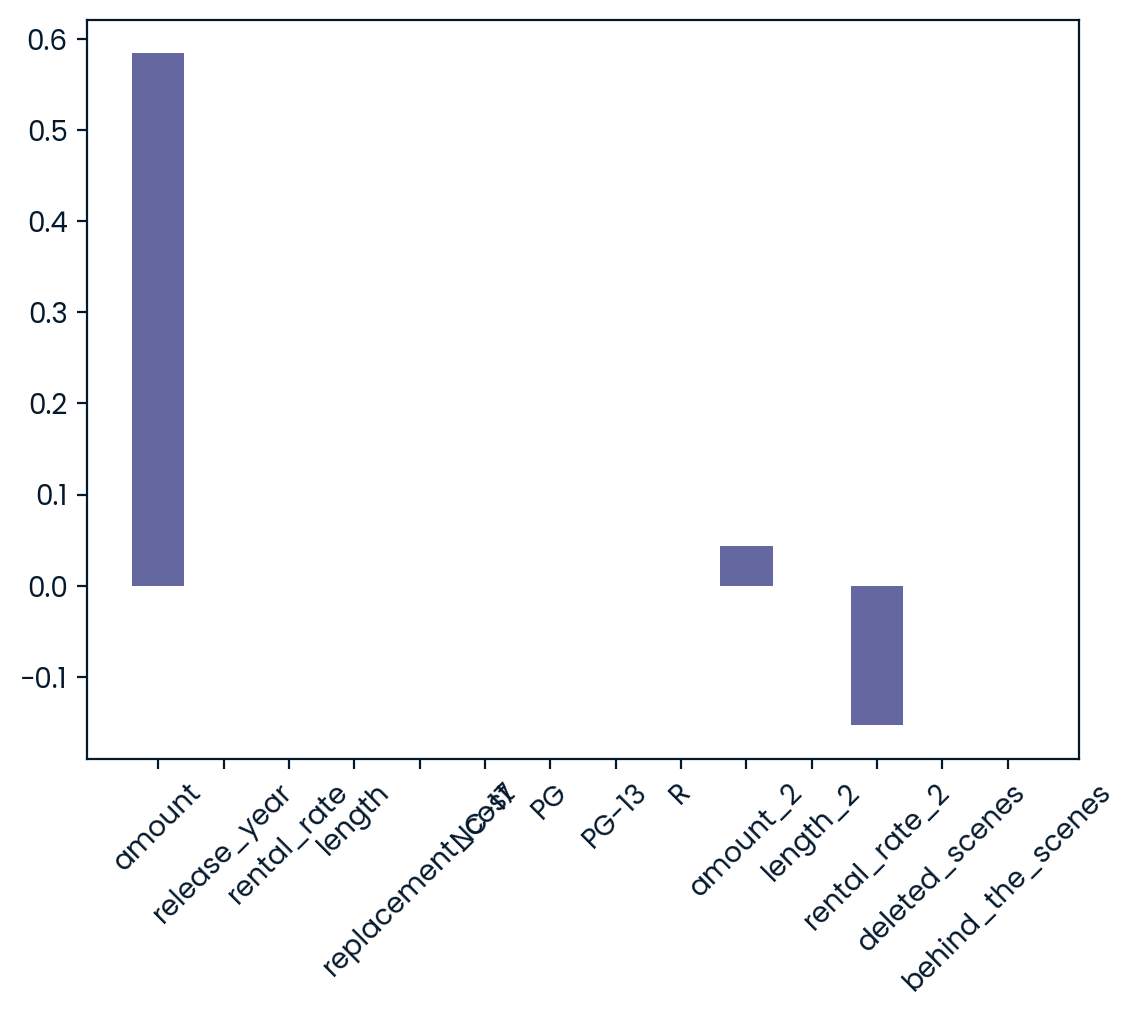

In [56]:
#lasso feature selection
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

lasso = Lasso(alpha=0.3, random_state=9) 
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_
plt.bar(X_train.columns, lasso_coef)
plt.xticks(rotation=45)
plt.show()

In [57]:
# Perform feature selectino by choosing columns with positive coefficients
X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef > 0], X_test.iloc[:, lasso_coef > 0]

In [58]:
X_lasso_train

,amount,amount_2,length_2
6682,2.99,8.9401,8100.0
8908,4.99,24.9001,2809.0
11827,6.99,48.8601,29241.0
6153,2.99,8.9401,5329.0
10713,5.99,35.8801,14884.0
...,...,...,...
6200,1.99,3.9601,24649.0
501,6.99,48.8601,18225.0
6782,5.99,35.8801,31329.0
4444,2.99,8.9401,28561.0


In [59]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols = ols.fit(X_lasso_train, y_train)
y_test_pred = ols.predict(X_lasso_test)
mse_lin_reg_lasso = mean_squared_error(y_test, y_test_pred)
if mse_lin_reg_lasso > 3:
    print("Not Good")

Not Good


In [60]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

param_dist_tree = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

param_dist_forest = {'n_estimators': np.arange(1,101,1),
          'max_depth':np.arange(1,11,1)}

tree_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()

In [61]:
rand_search_tree = RandomizedSearchCV(tree_reg, 
                                 param_distributions=param_dist_tree, 
                                 cv=5,
                                 n_iter=10,
                                 random_state=9)
rand_search_tree.fit(X_train, y_train)
y_pred = rand_search_tree.predict(X_test)

# Evaluate the model performance (optional)
mse_tree = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse_tree)

Mean Squared Error: 2.2180237751875778


In [62]:
rand_search_forest = RandomizedSearchCV(rf_reg, 
                                 param_distributions=param_dist_forest, 
                                 cv=5,
                                 n_iter=10,
                                 random_state=9)

rand_search_forest.fit(X_train, y_train)
y_pred = rand_search_forest.predict(X_test)

# Evaluate the model performance (optional)
mse_rf = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse_rf)

Mean Squared Error: 2.2138045197599534


In [63]:
hyper_params = rand_search_forest.best_params_
rf = RandomForestRegressor(n_estimators=hyper_params["n_estimators"], 
                           max_depth=hyper_params["max_depth"], 
                           random_state=9)

In [64]:
best_model = rf
best_mse = mse_rf